# 2.8 Inter-spike interval モデル
これまで紹介したモデルでは、入力に対する膜電位などの時間変化に基づき発火が起こるかどうか、ということを考えてきた。この節では、発火が生じるまでの過程を考慮せず、発火の時間間隔(**inter-spike interval, ISI**)の統計による現象論的モデルを考える。これを**Inter-spike interval (ISI)** モデルと呼ぶ。ISIモデルは**点過程(point process)** という統計的モデルに基づいており、各モデルにはISIが従う分布の名称がついている。

この節では、使用頻度の高い **ポアソン過程 (Poisson process) モデル**、ポアソン過程モデルにおいて不応期を考慮した **死時間付きポアソン過程 (Poisson process with dead time, PPD) モデル**、皮質の定常発火においてポアソン過程モデルよりも当てはまりがよいとされる **ガンマ過程 (Gamma process) モデル**について説明する。

なお、SNNにおいて、ISIモデルは主に画像入力の際に**連続値からスパイク列へのエンコード**に用いられる。これに限らず入力として用いられることが多い。

````{margin}
```{note}
この節は ([島崎, "スパイク統計モデル入門"](https://www.neuralengine.org/res/book/index.html); [Pachitariu, Probabilistic models for spike trains of single neurons"](http://www.gatsby.ucl.ac.uk/~marius/papers/SpikTrainStats.pdf)) を特に参考にした。
```
````

## 2.8.1 ポアソン過程モデル
### 点過程とポアソン過程
時間に応じて変化する確率変数のことを**確率過程(stochastic process)** という。さらに確率過程の中で、連続時間軸上において離散的に生起する点事象の系列を**点過程(point process)** という。スパイクは離散的に起こるので、点過程を用いてモデル化ができるという話である。

ポアソン過程 (Poisson process)は点過程の1つである。ポアソン過程モデルはスパイクの発生をポアソン過程でモデル化したもので、このモデルによって生じるスパイクをポアソンスパイク(Poisson spike)と呼ぶ。ポアソン過程では、時刻$t$までに起こった点の数$N(t)$はポアソン分布に従う。すなわち、点が起こる確率が強度$\lambda$のポアソン分布に従う場合, 時刻$t$までに事象が$n$回起こる確率は$P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$となる。 

ポアソン過程において点が起こる回数がポアソン分布に従うことは、ポアソン過程という名称の由来となっている。これを定義とする場合もあれば、次の4条件を満たす点過程をポアソン過程とするという定義もある。

- 時刻0における初期の点の数は0 : $P[N(0)=0]=1$ 
- $[t, t+\Delta t)$に点が1つ生じる確率 : $P[N(t+\Delta t)-N(t)=1]=\lambda(t)\Delta t+o(\Delta t)$
- 微小時間$\Delta t$の間に点は2つ以上生じない : $P[N(t+\Delta t)-N(t)=2]=o(\Delta t)$
- 任意の時点$t_1 < t_2 < \cdots< t_n$に対して，増分 $N(t_2)-N(t_1), N(t_3)-N(t_2), \cdots, N(t_n)-N(t_{n−1})$は互いに独立である．

ただし, $o(\cdot)$はLandauの記号(Landauのsmall o)であり, $o(x)$は$x\to 0$のとき、$o(x)/x\to 0$となる微小な量を表す。ポアソン過程に従ってスパイクが生じるとする場合、条件2の強度関数$\lambda(t)$は**発火率**を意味する (また実装において有用)。条件3は不応期より小さいタイムステップにおいては、1つのタイムステップにおいて1つしかスパイクは生じないということを表す。条件4はスパイクは独立に発生する、ということを意味する。また、これらの条件から$N(t)$の分布は強度母数$\lambda(t)$のポアソン分布に従うことが示せる。

強度関数(点がスパイクの場合、発火率)が$\lambda(t)=\lambda$ (定数)となる場合は点の時間間隔(点がスパイクの場合、ISI)の確率変数$T$が強度母数$\lambda$の **指数分布**に従う。なお、指数分布の確率密度関数は確率変数を$T$とするとき、

$$
f(t;\lambda )=\left\{{\begin{array}{ll}\lambda e^{-\lambda t}&(t\geq 0)\\0&(t<0)\end{array}}\right.
$$

となる。このことは4条件とChapman-Kolmogorovの式により求められるが、ややこしいので, $P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$から導出できることを簡単に示す。指数分布の累積分布関数を$F(t; \lambda)$とすると、

$$
F(t; \lambda) = P(T<t)=1-P(T>t)=1-P(N(t)=0)=1-e^{-\lambda t}
$$

となる。よって

$$
f(t; \lambda)=\frac{dF(t; \lambda)}{dt}=\lambda e^{-\lambda t}
$$

が成り立つ。

### 定常ポアソン過程
ここからポアソン過程によるスパイクのシミュレーションを実装する。実装方法にはISIが指数分布に従うことを利用したものと、ポアソン過程の条件2を利用したものの2通りがある。実装は後者が楽で計算量も少ないが、後のガンマ過程のために前者の実装を先に行う。

#### ISIの累積により発火時刻を求める手法
ISIが指数分布に従うことを利用してポアソン過程モデルの実装を行う。まずISIを指数分布に従う乱数とする。次にISIを累積することで発火時刻を得る。最後に発火時間を整数値に丸めてindexとすることで$\{0, 1\}$のスパイク列が得られる。ISIの取得には`Random.randexp()`を用いる。この関数は scale 1の指数分布に従う乱数を返す。このscaleは指数分布の確率密度関数を$f(t; \frac{1}{\beta}) = \frac{1}{\beta} e^{-t/\beta}$とした際の$\beta = 1/\lambda$である(この時、平均は$\beta$となる)。よって発火率を`fr`(1/s), 単位時間を`dt`(s)としたときのISIは `isi = 1/(fr*dt) * randexp()`として得ることができる。

まず必要なパッケージを読み込む。

In [1]:
using Random
using Plots

乱数のseed値を設定し、必要な定数を定義した後に`isi`を計算する。`isi`を累積することでスパイクの生じた時刻を記録する配列`spike_time`を作成する。作成後、`spike_time`を用いてラスタープロットを描画する。

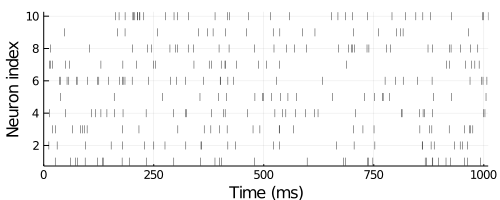

In [2]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

isi = 1/(fr*dt*1e-3) * randexp(Int32(nt*1.5/fr), n_neurons)
spike_time = cumsum(isi, dims=1) # ISIを累積

# raster plot
p = plot(xlabel ="Time (ms)", ylabel="Neuron index", xlim =(0, T+10), legend=false, size=(500, 200))
for i=1:n_neurons
    scatter!(p, spike_time[:, i], i*ones(Int32(nt*1.5/fr)), shape=:vline, color="black")
end
display(p)

`spike_time`のように発火時刻で記録しておく方がメモリを節約できるが、シミュレーションにおいてはスパイク列$S$はタイムステップごとに発火しているかを表す$\{0,1\}$配列で保持しておくと楽に扱うことができる。そのため冗長ではあるが、発火時刻の配列を$\{0,1\}$配列`spikes`に変換しスパイクの数と発火率を計算する。

In [3]:
spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
spike_time = round.(Int32, spike_time) # float to int
spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

for i=1:n_neurons    
    spikes[spike_time[:, i], i] .= 1
end

spikes[1] = 0 # (spike_time=1)の発火を削除
println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 293
Firing rate : 29.3Hz


#### $\Delta t$ 間の発火確率が $\lambda\Delta t$ であることを利用する方法
次に2番目のポアソン過程モデルの実装を行う。こちらは$\lambda$を発火率とした場合, 区間$[t, t+\Delta t)$の間にポアソンスパイクが発生する確率は$\lambda \Delta t$となることを利用する。これはポアソン過程の条件だが、ポアソン分布から導けることを簡単に示しておく。事象が起こる確率が強度$\lambda$のポアソン分布に従う場合, 時刻$t$までに事象が$n$回起こる確率は$P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$となる。よって, 微小時間$\Delta t$において事象が$1$回起こる確率は

$$
P[N(\Delta t)=1]=\dfrac{\lambda \Delta t}{1 !} e^{-\lambda \Delta t}\simeq \lambda \Delta t+o(\Delta t)
$$

となる。ただし, $e^{-\lambda \Delta t}$についてはマクローリン展開による近似を行っている。このことから, 一様分布$U(0,1)$に従う乱数$\xi$を取得し, $\xi<\lambda dt$なら発火$(y=1)$, それ以外では$(y=0)$となるようにすればポアソンスパイクを実装できる。

In [4]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = Int32(10) # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 304
Firing rate : 30.4Hz


In [5]:
function rasterplot(spikes, plotsize=(500, 200))
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes))
    spike_time = first.(spike_inds)
    neuron_inds = last.(spike_inds)
    
    # raster plot
    scatter(spike_time, neuron_inds,
        xlabel ="Time (ms)", ylabel="Neuron index",
        shape=:vline, color="black",
        legend=false, size=plotsize)
end

rasterplot (generic function with 2 methods)

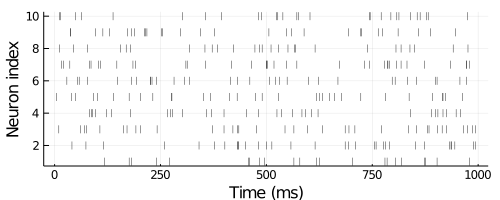

In [6]:
rasterplot(spikes)

なお、ここでは全時間における発火をまとめて計算しているが、タイムステップごとに発火の有無を計算することもできる。前者は発火情報を保持するためのメモリが必要だが、計算時間は短くなる。後者はメモリの節約になるが、計算時間は長くなる。そのため、これら2つの方法はメモリと計算時間のトレードオフとなる。また、他には発火情報を疎行列(sparse matrix)の形式で保持しておくとメモリの節約になると思われる。

### 非定常ポアソン過程
これまでの実装は発火率$\lambda$が一定であるとする、定常ポアソン過程 (homogeneous poisson process)であったが、ここからは発火率$\lambda(t)$が時間変化するとする**非定常ポアソン過程** (inhomogeneous poisson process)について考える。とはいえ、定常ポアソン過程における発火率を、時間についての関数で置き換えるだけで実装できる。以下は$\lambda(t)=\sin^2(\alpha t)$(ただし$\alpha$は定数)とした場合の実装である。

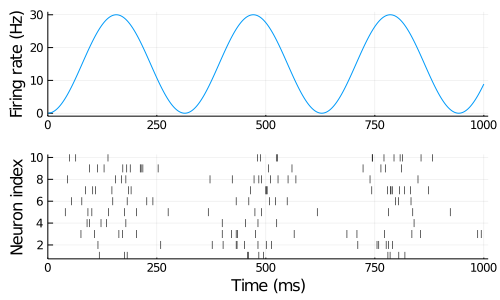

In [7]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = Int32(10) # ニューロンの数

t = Array{Float32}(1:nt)*dt
fr = 30(sin.(1e-2t)).^2 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

p1 = plot(t, fr, ylabel ="Firing rate (Hz)", legend=false)
p2 = rasterplot(spikes)
plot(p1, p2, xlim=(0, T+10), layout = grid(2, 1, heights=[0.5, 0.5]), size=(500,300))

上が発火率$\lambda(t)$の時間変化, 下がラスタープロットである。

## 2.8.2 死時間付きポアソン過程モデル (Poisson process with dead time, PPD)
ポアソン過程は簡易的で有用だが、不応期を考慮していない。そのため、時には生理的範疇を超えたバースト発火が起こる場合もある[^burst]。そこで、ポアソン過程において不応期のようなイベントの生起が起こらない **死時間(dead time)** [^deadtime]を考慮した**死時間付きポアソン過程 (Poisson process with dead time, PPD)** (またはdead time modified Poisson process)というモデルを導入する。

実装においてはLIFニューロンの時と同じような不応期の処理をする。つまり、現在が不応期かどうかを判断し、不応期なら発火を許可しないようにする。

[^burst]: 複数のニューロンからの発火の重ね合わせ(superposition)であると考えることもできる。
[^deadtime]: 例えば、ガイガー・カウンター(Geiger counter)などの放射線の検出器には放射線の到達を機器の物理的特性として検出できない時間(つまり死時間)がある。そのため放射線の到達数がポアソン分布に従うとした場合、放射線測定装置のモデルとしてPPDが用いられる。

In [8]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps
tref = 5f0 # 不応期 (ms)

n_neurons = Int32(10) # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

tlast = zeros(n_neurons) # 発火時刻の記録変数
spikes = zeros(nt, n_neurons)

# simulation
@time for i=1:nt
    fire = rand(n_neurons) .< fr*dt*1e-3
    spikes[i, :] = ((dt*i) .> (tlast .+ tref)) .* fire
    tlast[:] = tlast .* (1 .- fire) + dt*i * fire # 発火時刻の更新
end

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

  0.394458 seconds (1.60 M allocations: 77.271 MiB, 3.87% gc time)
Num. of spikes : 267.0
Firing rate : 26.700000000000003Hz


`struct`や`function`を定義しても良いが、ここではforループ内に直接処理を書いた。forループ内に関しては以下のようにニューロンごとに処理しても良い (速度に大きな差はない)。

```julia
# simulation
@time for i=1:nt
    fire = rand(n_neurons) .< fr*dt*1e-3
    for j=1:n_neurons
        spikes[i, j] = ifelse(dt*i > tlast[j] + tref, fire[j], 0)
        tlast[j] = ifelse(fire[j], dt*i*fire[j], tlast[j]) # 発火時刻の更新
    end
end
```

また、不応期があるために発火率は設定値の30Hzよりも低くなっていることが分かる。次にラスタープロットを描画する。

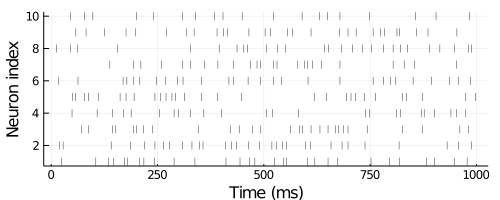

In [9]:
rasterplot(spikes)

通常のPoisson spikeと差はあまり感じられないが、高頻度発火の場合に通常のモデルとの違いが明瞭となる。

## 2.8.3 ガンマ過程モデル
ガンマ過程(gamma process)は点の時間間隔がガンマ分布に従うとするモデルである。ガンマ過程はポアソン過程よりも皮質における定常発火への当てはまりが良いとされている ([Shinomoto, et al., 2003](https://pubmed.ncbi.nlm.nih.gov/14629869/); [Maimon & Assad,2009](https://pubmed.ncbi.nlm.nih.gov/19447097/))。

時間間隔の確率変数を$T$とした場合、ガンマ分布の確率密度関数は

$$
\begin{equation}
f(t;k,\theta) =  t^{k-1}\frac{e^{-t/\theta}}{\theta^k\Gamma(k)}
\end{equation}
$$

と表される。ただし、$t > 0$であり、 2つの母数は$k, \theta > 0$である。また、$\Gamma (\cdot)$はガンマ関数であり、

$$
\begin{equation}
\Gamma (k)=\int _{0}^{\infty }x^{k-1}e^{-x}\,dx
\end{equation}
$$

と定義される。ガンマ分布の平均は$k\theta$だが、発火率はISIの平均の逆数なので、$\lambda=1/k\theta$となる。また、$k=1$のとき、ガンマ分布は指数分布となる。さらに$k$が正整数のとき、ガンマ分布はアーラン分布となる。

ガンマ過程モデルの実装はポアソン過程モデルのISIを累積する手法と同様に書くことができる。ただしこの時、[Distributions.jl](https://github.com/JuliaStats/Distributions.jl)を用いる。基本的には`randexp(shape)`を`rand(Gamma(a,b), shape)`に置き換えればよい (もちろん多少の修正は必要とする)。

In [10]:
using Distributions 

スパイク列を生成する関数を書く。少々冗長なのが気になる点である。

In [11]:
function GammaSpike(T, dt, n_neurons, fr, k)
    nt = Int32(T/dt) # number of timesteps
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)

    isi = rand(Gamma(k, theta), Int32(round(nt*1.5/fr)), n_neurons)
    spike_time = cumsum(isi, dims=1) # ISIを累積

    spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
    spike_time = round.(Int32, spike_time) # float to int
    spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

    for i=1:n_neurons    
        spikes[spike_time[:, i], i] .= 1
    end

    spikes[1] = 0 # (spike_time=1)の発火を削除
    return spikes
end

GammaSpike (generic function with 1 method)

`GammaSpike` 関数を用いて $k=1, 12$ の場合のシミュレーションを実行する。なお、$k=1$のときはポアソン過程に一致することに注意しよう。

In [12]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ガンマスパイクの発火率(Hz)

# k=1のときはポアソン過程に一致
spikes1 = GammaSpike(T, dt, n_neurons, fr, 1)
spikes2 = GammaSpike(T, dt, n_neurons, fr, 12)

println("Num. of spikes : ", sum(spikes1), ", ",sum(spikes2))
println("Firing rate : ", sum(spikes1)/(n_neurons*T)*1e3, "Hz, ", sum(spikes2)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 289, 301
Firing rate : 28.9Hz, 30.099999999999998Hz


ISIの分布を描画するための関数を定義する。

In [13]:
function GammaISIplot(dt, fr, k, n=1000)
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)
    isi = rand(Gamma(k, theta), n)
    gamma_pdf = pdf.(Gamma(k, theta), minimum(isi):maximum(isi))

    p = plot(legend=false, xlabel="ISI (ms)", ylabel="Density")
    histogram!(p, isi, normed=true)
    plot!(p, minimum(isi):maximum(isi), gamma_pdf, color="black")
end

GammaISIplot (generic function with 2 methods)

結果を尿がする。上段はISIの分布、下段はラスタープロットである。左の$k=1$の場合をポアソン過程モデルのスパイク列と比較しよう (同じ外観になっていることが分かる)。右は$k=12$とした場合である。

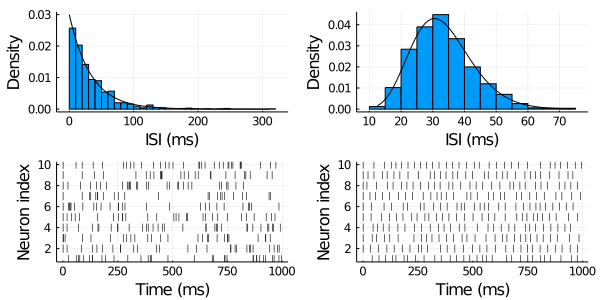

In [14]:
p1 = GammaISIplot(dt, fr, 1)
p2 = GammaISIplot(dt, fr, 12)
p3 = rasterplot(spikes1)
p4 = rasterplot(spikes2)
plot(p1, p2, p3, p4,
    layout = grid(2, 2, widths=[0.5, 0.5], heights=[0.5, 0.5]), legend = false, size=(600, 300))

なお、前述したようにガンマ過程モデルの方がポアソン過程モデルよりも皮質ニューロンのモデルとしては優れているが、入力画像のエンコーディングをガンマ過程モデルにすることでSNNの認識精度が向上するかどうかはまだ十分に研究されていない。また、([Deger, et al., 2012](https://pubmed.ncbi.nlm.nih.gov/21964584/))ではPPDやガンマ過程の重ね合わせによるスパイク列を生成するアルゴリズムを考案している。